In [1]:
import numpy as np
import pandas as pd
import torch as th
import torch.nn as nn
import gymnasium as gym
from gumbo.environment.wrappers import TorchIO
from gumbo.data.collector import Collector
from gumbo.data.buffers import EpisodicBuffer
from gumbo.policy.discrete import CategoricalPolicy
from gumbo.policy.continuous import DiagonalGaussianPolicy
from gumbo.learn.ppo import PPO

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
env = gym.vector.SyncVectorEnv(1 * [lambda: gym.make("BipedalWalker-v2")])
env = TorchIO(env)

In [16]:
dfs = []

best_return = 0
best_policy = None

for i in range(5):
    policy = DiagonalGaussianPolicy(
        nn.Sequential(
            nn.Linear(env.flat_dim, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, env.logit_dim)
        )
    )

    critic = nn.Sequential(
        nn.Linear(env.flat_dim, 64),
        nn.Tanh(),
        nn.Linear(64, 64),
        nn.Tanh(),
        nn.Linear(64, 1)
    )

    buff = EpisodicBuffer(env, 2048)

    collector = Collector(env, policy, buff)

    ppo = PPO(policy, critic, collector)
    rews, lens = ppo.learn(int(1e6))
    rews = np.array(rews)
    lens = np.array(lens)

    max_return = np.max(rews)
    if max_return > best_return:
        best_return = max_return
        best_policy = policy

    n = 100
    moveavg_rew = np.cumsum(np.pad(rews, (n, 0)))
    moveavg_rew = moveavg_rew[n:] - moveavg_rew[:-n]
    moveavg_rew = moveavg_rew / np.minimum(np.arange(1, len(rews)+1), n)
    sum_ep_lens = np.cumsum(lens)

    dfs.append(pd.DataFrame({
        "reward": rews,
        "reward_ma": moveavg_rew,
        "timestep": sum_ep_lens,
        "run": i
    }))

    print("Completed run", i)

data = pd.concat(dfs)

-161.20435333251953
-147.96222865327874
-144.31640849393958
-151.18306068356117
-148.51956337451935
-143.95997426629066
-159.34126670479773
-153.76460694909096
-150.42520484566688
-142.6682972252369
-136.07364176869393
-133.38271224021912
-113.05610840439796
-106.00994518876075
-100.75609896302223
-96.1180164206028
-95.82526751160621
-92.79556844353675
-88.84728318810463
-79.59410150170326
-77.34707268357278
-75.81789870858192
-70.63762984633446
-68.88035891890526
-65.4048920571804
-65.85869904875756
-62.36010372519493
-60.73891419172287
-54.65288574934006
-56.89129941701889
-53.301426331996915
-54.36610579252243
-50.30023461103439
-48.86580738782882
-50.09769245862961
-44.7582269358635
-37.80425827741623
-37.59583045244217
-35.42810263872147
-37.58736409187317
-35.12085799217224
-29.999859228134156
-30.170748157501222
-28.091416320800782
-28.170173554420472
-28.712677903175354
-28.009900727272033
-27.53640146970749
-27.243978391885758
-28.52786083817482
-28.03157849431038
-23.70645138

In [17]:
data.head()

,reward,reward_ma,timestep,run
0,-84.648987,-84.648987,103,0
1,-101.079002,-92.863995,229,0
2,-286.461365,-157.396451,310,0
3,-214.279617,-171.617243,392,0
4,-86.449646,-154.583723,515,0


In [20]:
data["round_t"] = np.ceil(data.timestep / 1000) * 1000

C:\Users\jwmcc\AppData\Local\Temp\ipykernel_8288\1881804620.py:3: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.lineplot(data=data, x="timestep", y="reward_ma", hue="run",


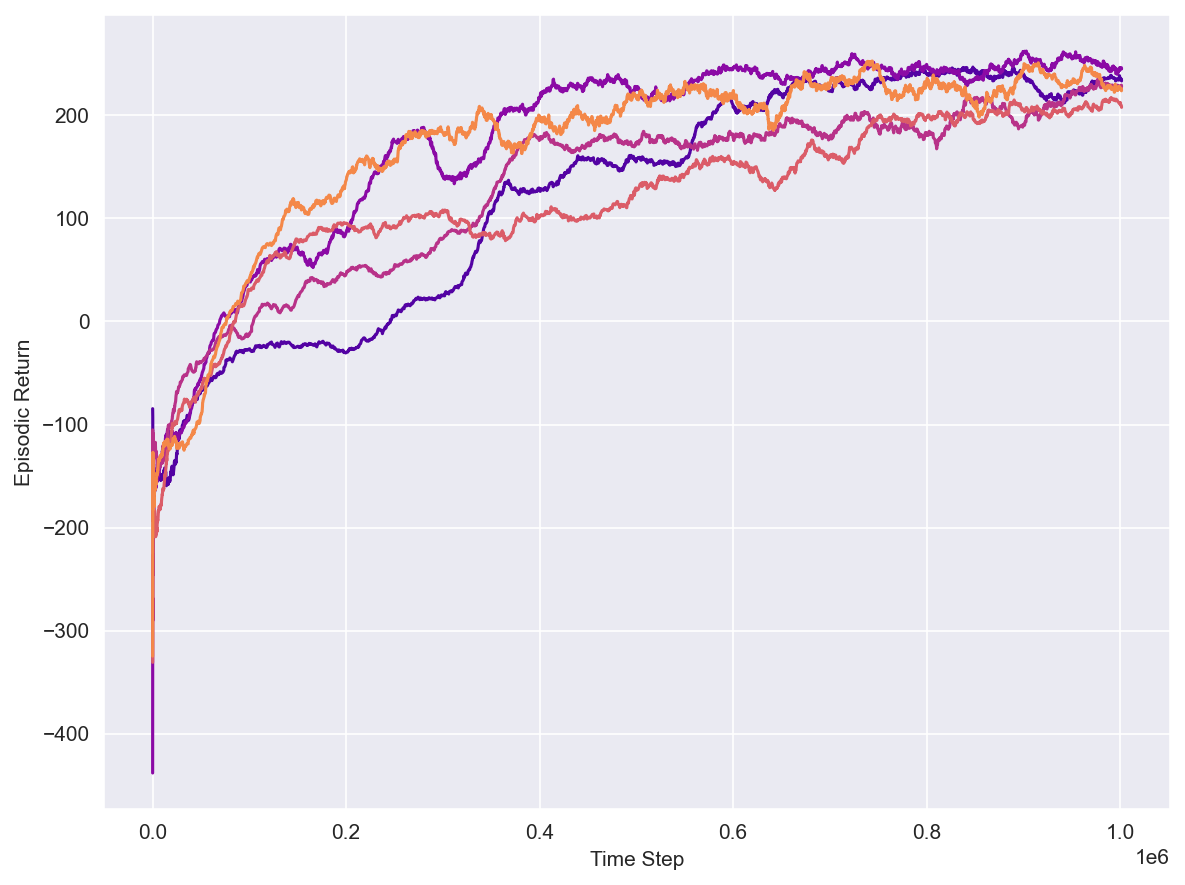

In [28]:
plt.figure(figsize=(8, 6), dpi=150)
sns.set_style("darkgrid")
sns.lineplot(data=data, x="timestep", y="reward_ma", hue="run",
             palette=sns.color_palette(palette="plasma"), legend=False, estimator="mean", err_kws={"edgecolor": None})
plt.xlabel("Time Step")
plt.ylabel("Episodic Return")
plt.tight_layout()
plt.savefig("../jwmccarthy.github.io/assets/lunar_lander_5_runs.png", facecolor=(1,1,1,0))
plt.show()

In [29]:
from gymnasium.wrappers import RecordVideo

trigger = lambda t: t % 1000 == 0

env = gym.make("LunarLander-v2", render_mode="rgb_array")
env = RecordVideo(env, video_folder="./videos", episode_trigger=trigger, disable_logger=True)

obs, _ = env.reset()

for i in range(2000):
    action = policy(th.as_tensor(obs))
    obs, rew, term, trunc, info = env.step(action.detach().numpy())
    if term or trunc:
        obs, _ = env.reset()

c:\Users\jwmcc\anaconda3\envs\rlenv\lib\site-packages\gymnasium\wrappers\record_video.py:94: UserWarning: WARN: Overwriting existing videos at c:\Users\jwmcc\Documents\RL\Gumbo\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
